Signature length for a 2D path at level 4: 30
Sample path: [100.0, 99.99011521187965, 100.71565611959726, 100.71027360145892, 100.42621838533904, 100.74884689140218, 100.43567190344947, 100.48663677902925, 100.40180847714235, 100.43399536903952, 100.42207424821117]


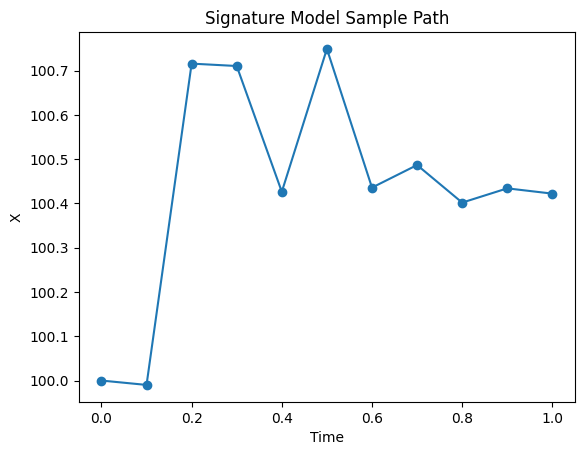

In [6]:
import numpy as np
import iisignature
import matplotlib.pyplot as plt

def simulate_brownian_motion(times):
    """
    Simulate a one-dimensional Brownian motion at the sampling times.
    """
    times = np.array(times)
    dt = np.diff(times)
    increments = np.sqrt(dt) * np.random.randn(len(dt))
    W = np.concatenate(([0.0], np.cumsum(increments)))
    return W

def lead_lag_transform(W):
    """
    Apply the lead–lag transformation to the 1D path W.
    
    For a path W = [w0, w1, ..., wn], the lead–lag transform is given by:
      [(w0, w0), (w1, w0), (w1, w1), (w2, w1), ..., (wn, w_{n-1}), (wn, wn)]
    """
    W = np.array(W)
    n = len(W)
    lead, lag = [], []
    for i in range(n):
        # Diagonal point
        lead.append(W[i])
        lag.append(W[i])
        if i < n - 1:
            # Off-diagonal point: lead jumps, lag remains constant
            lead.append(W[i+1])
            lag.append(W[i])
    return np.column_stack((lead, lag))

def sample_signature_model(times, ell, x, level=4):
    """
    Sample from the Signature Model.
    
    Parameters:
      times : array-like, sampling times with t0 = 0 and tn = T.
      ell   : NumPy array of model parameters (signature weights).
              For a 2D path at level 4, the length should be 
              iisignature.siglength(2, level).
      x     : initial spot price.
      level : truncation level of the signature (default is 4).
    
    Returns:
      X : list of model values at the sampling times.
      
    Instead of composing signatures iteratively (via Chen’s identity),
    we compute the signature on the entire prefix of the lead–lag path.
    """
    # Step 1: simulate Brownian motion
    W = simulate_brownian_motion(times)
    # Step 2: obtain the 2D lead–lag path
    W_LL = lead_lag_transform(W)
    
    d = 2
    sig_length = iisignature.siglength(d, level)
    n = len(times)
    X = []
    
    # For each sampling time t_k, compute the signature on the prefix of W_LL.
    # Note: for a 1D path with n time points, the lead–lag transform has 2*n - 1 points.
    # The natural correspondence is to take the first (2*k + 1) points for t_k.
    for k in range(n):
        end_index = 2 * k + 1
        # In case of any index overshoot (shouldn't occur for k = n-1),
        # restrict to the length of W_LL.
        end_index = min(end_index, len(W_LL))
        segment = W_LL[:end_index]
        sig_k = iisignature.sig(segment, level)
        # Compute X_{t_k} = x + <ell, signature>
        X_tk = x + np.dot(ell, sig_k)
        X.append(X_tk)
    
    return X

# Example usage:
if __name__ == '__main__':
    # Define sampling times (for example, 11 equally spaced points from 0 to 1)
    times = np.linspace(0, 1, 11)
    level = 4
    d = 2
    sig_length = iisignature.siglength(d, level)
    print("Signature length for a 2D path at level {}: {}".format(level, sig_length))
    
    # Generate a dummy parameter vector ell.
    # In practice, use your calibrated parameter vector.
    np.random.seed(42)
    ell = np.random.randn(sig_length)
    
    # Set the initial spot price.
    x0 = 100.0
    # Sample the path from the signature model.
    sample_path = sample_signature_model(times, ell, x0, level)
    
    print("Sample path:", sample_path)
    
    # Plot the sample path.
    plt.plot(times, sample_path, marker='o')
    plt.xlabel("Time")
    plt.ylabel("X")
    plt.title("Signature Model Sample Path")
    plt.show()
